In [2]:
import time
ts = time.time()
print(ts)
print(time.ctime(ts))

1554794333.204129
Tue Apr  9 12:48:53 2019


In [3]:
from datetime import datetime
now = datetime.fromtimestamp(ts)
print(now)
print(datetime.timestamp(now))


2019-04-09 12:48:53.204129
1554794333.204129


In [4]:
start_time = time.process_time()
print("krishna")
end_time = time.process_time()
print('operation executed in ', end_time - start_time)

krishna
operation executed in  0.00041200000000007897


In [20]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics, model_selection
color = sns.color_palette()
%matplotlib inline
pd.options.mode.chained_assignment = None 

In [22]:
order_products_train = pd.read_csv("order_products__train.csv")
order_products_prior = pd.read_csv("order_products__prior.csv")
orders = pd.read_csv("orders.csv")
products = pd.read_csv("products.csv")
aisles = pd.read_csv("aisles.csv")
departments = pd.read_csv("departments.csv")

In [23]:
print("The order_products_train size is : ", order_products_train.shape)
print("The order_products_prior size is : ", order_products_prior.shape)

The order_products_train size is :  (1384617, 4)
The order_products_prior size is :  (32434489, 4)


In [24]:
order_products_all = pd.concat([order_products_train, order_products_prior], axis=0)

print("The order_products_all size is : ", order_products_all.shape)

The order_products_all size is :  (33819106, 4)


In [25]:
total = order_products_all.isnull().sum().sort_values(ascending=False)
percent = (order_products_all.isnull().sum()/order_products_all.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total Missing', 'Percent'])
missing_data

Total Missing  Percent
reordered                      0      0.0
add_to_cart_order              0      0.0
product_id                     0      0.0
order_id                       0      0.0

In [26]:
start_time = time.process_time()
grouped = order_products_all.groupby("reordered")["product_id"].aggregate({'Total_products': 'count'}).reset_index()
grouped['Ratios'] = grouped["Total_products"].apply(lambda x: x /grouped['Total_products'].sum())
grouped
end_time = time.process_time()
print('operation executed in ', end_time - start_time)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


operation executed in  3.8412119999999987


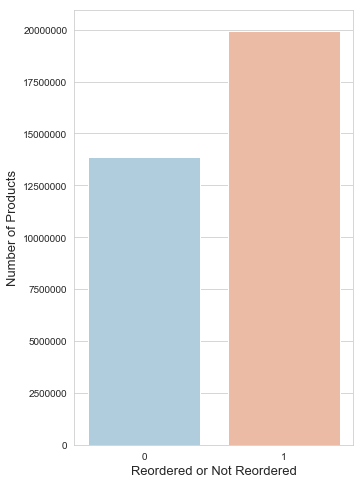

operation executed in  0.38130100000000056


In [27]:
start_time = time.process_time()
grouped  = grouped.groupby(['reordered']).sum()['Total_products'].sort_values(ascending=False)

sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(5, 8))
sns.barplot(grouped.index, grouped.values, palette='RdBu_r')
plt.ylabel('Number of Products', fontsize=13)
plt.xlabel('Reordered or Not Reordered', fontsize=13)
plt.ticklabel_format(style='plain', axis='y')
plt.show()
end_time = time.process_time()
print('operation executed in ', end_time - start_time)

In [28]:
orders_df = pd.read_csv( "orders.csv", usecols=["order_id","user_id","order_number"])

In [29]:
prior_df = pd.read_csv( "order_products__prior.csv")

# merge with the orders file to get the user_id #
prior_df = pd.merge(prior_df, orders_df, how="inner", on="order_id")
prior_df.head()

order_id  product_id  add_to_cart_order  reordered  user_id  order_number
0         6       40462                  1          0    22352             4
1         6       15873                  2          0    22352             4
2         6       41897                  3          0    22352             4
3         8       23423                  1          1     3107             5
4        13       17330                  1          0    45082             2

In [30]:
prior_grouped_df = prior_df.groupby("user_id")["order_number"].aggregate("max").reset_index()
prior_df_latest = pd.merge(prior_df, prior_grouped_df, how="inner", on=["user_id", "order_number"])
prior_df_latest = prior_df_latest[["user_id", "product_id", "reordered"]]
prior_df_latest.columns = ["user_id", "product_id", "reordered_latest"]
prior_df_latest.head()

user_id  product_id  reordered_latest
0    59897        9755                 1
1    59897       31487                 0
2    59897       37510                 1
3    59897       14576                 1
4    59897       22105                 0

In [31]:
prior_df_agg = prior_df.groupby(["user_id","product_id"])["reordered"].aggregate(["count", "sum"]).reset_index()
prior_df_agg.columns = ["user_id", "product_id", "reordered_count", "reordered_sum"]
prior_df_agg.head()

user_id  product_id  reordered_count  reordered_sum
0        1         196               10              9
1        1       10258                9              8
2        1       10326                1              0
3        1       12427               10              9
4        1       13032                3              2

In [32]:
prior_df_merge = pd.merge(prior_df_agg, prior_df_latest, how="left", on=["user_id","product_id"])
prior_df_merge.head()

user_id  product_id  reordered_count  reordered_sum  reordered_latest
0        1         196               10              9               1.0
1        1       10258                9              8               1.0
2        1       10326                1              0               NaN
3        1       12427               10              9               1.0
4        1       13032                3              2               1.0

In [33]:
train_df = pd.read_csv("order_products__train.csv", usecols=["order_id"])
train_df.head()

order_id
0         1
1         1
2         1
3         1
4         1

In [34]:
train_df = train_df.groupby("order_id").aggregate("count").reset_index()
train_df.head()

order_id
0         1
1        36
2        38
3        96
4        98

In [35]:
train_df = pd.merge(train_df, orders_df, how="inner", on="order_id")
train_df.head()

order_id  user_id  order_number
0        38    42756             6
1        96    17227             7
2        98    56463            41
3       226    51011             4
4       762    41751             5

In [36]:
test_df = pd.read_csv("sample_submission.csv", usecols=["order_id"])

test_df = pd.merge(test_df, orders_df, how="inner", on="order_id")
test_df.head()

order_id  user_id  order_number
0        17    36855             5
1        34    35220            20
2       257    35581             9
3       386    55492             8
4       418    33565            12

In [37]:
print(train_df.shape, test_df.shape)

(40096, 3) (23004, 3)


In [38]:
train_df = pd.merge(train_df, prior_df_merge, how="inner", on="user_id")
train_df.head()

order_id  user_id  order_number  product_id  reordered_count  \
0        38    42756             6        1940                2   
1        38    42756             6        2124                1   
2        38    42756             6        2314                1   
3        38    42756             6        4428                1   
4        38    42756             6        8012                4   

   reordered_sum  reordered_latest  
0              1               NaN  
1              0               0.0  
2              0               NaN  
3              0               NaN  
4              3               1.0

In [39]:
test_df = pd.merge(test_df, prior_df_merge, how="inner", on="user_id")
#del prior_df, prior_grouped_df, prior_df_latest
test_df.head()

order_id  user_id  order_number  product_id  reordered_count  \
0        17    36855             5        1283                1   
1        17    36855             5        6291                1   
2        17    36855             5        7035                1   
3        17    36855             5       11494                1   
4        17    36855             5       13107                3   

   reordered_sum  reordered_latest  
0              0               NaN  
1              0               NaN  
2              0               NaN  
3              0               NaN  
4              2               1.0

In [40]:
products_df = pd.read_csv("products.csv", usecols=["product_id", "aisle_id", "department_id"])
products_df.head()

product_id  aisle_id  department_id
0           1        61             19
1           2       104             13
2           3        94              7
3           4        38              1
4           5         5             13

In [41]:
train_df = pd.merge(train_df, products_df, how="inner", on="product_id")
train_df.head()

order_id  user_id  order_number  product_id  reordered_count  \
0        38    42756             6        1940                2   
1      7916    30825             4        1940                3   
2      9934    48962            10        1940                4   
3     10812    37929            23        1940                1   
4     12847    37602             5        1940                1   

   reordered_sum  reordered_latest  aisle_id  department_id  
0              1               NaN        84             16  
1              2               1.0        84             16  
2              3               NaN        84             16  
3              0               NaN        84             16  
4              0               0.0        84             16

In [42]:
test_df = pd.merge(test_df, products_df, how="inner", on="product_id")
test_df.head()

order_id  user_id  order_number  product_id  reordered_count  \
0        17    36855             5        1283                1   
1    657743    16994            10        1283                1   
2   2829393    19117            53        1283                1   
3        17    36855             5        6291                1   
4     25782    31066             5        6291                1   

   reordered_sum  reordered_latest  aisle_id  department_id  
0              0               NaN       100             21  
1              0               NaN       100             21  
2              0               NaN       100             21  
3              0               NaN       121             14  
4              0               NaN       121             14

In [43]:
train_y_df = pd.read_csv("order_products__train.csv", usecols=["order_id", "product_id", "reordered"])
train_y_df = pd.merge(train_y_df, orders_df, how="inner", on="order_id")
train_y_df = train_y_df[["user_id", "product_id", "reordered"]]
train_df = pd.merge(train_df, train_y_df, how="left", on=["user_id", "product_id"])
train_df["reordered"].fillna(0, inplace=True)
print(train_df.shape)

(2588813, 10)


In [44]:
from numpy import loadtxt
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [45]:
X=train_df.drop('reordered',axis=1)

In [46]:
X.head()

order_id  user_id  order_number  product_id  reordered_count  \
0        38    42756             6        1940                2   
1      7916    30825             4        1940                3   
2      9934    48962            10        1940                4   
3     10812    37929            23        1940                1   
4     12847    37602             5        1940                1   

   reordered_sum  reordered_latest  aisle_id  department_id  
0              1               NaN        84             16  
1              2               1.0        84             16  
2              3               NaN        84             16  
3              0               NaN        84             16  
4              0               0.0        84             16

In [47]:
Y =train_df['reordered']

In [48]:
Y.head()

0    0.0
1    1.0
2    1.0
3    0.0
4    1.0
Name: reordered, dtype: float64

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

In [50]:
model = XGBClassifier()

In [51]:
start_time = time.process_time()
model.fit(X_train, y_train)
end_time = time.process_time()
print('operation executed in ', end_time - start_time)

operation executed in  168.741109


In [52]:
start_time = time.process_time()
y_pred = model.predict(X_test)
end_time = time.process_time()
print('operation executed in ', end_time - start_time)

operation executed in  2.1743470000000116


In [53]:
start_time = time.process_time()
predictions = [round(value) for value in y_pred]
end_time = time.process_time()
print('operation executed in ', end_time - start_time)

operation executed in  1.0464259999999967


In [54]:
start_time = time.process_time()
accuracy = accuracy_score(y_test, predictions)
end_time = time.process_time()
print('operation executed in ', end_time - start_time)

operation executed in  0.34538700000001654


In [55]:
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 90.71%


In [56]:
train_y = train_df.reordered.values

# dataframe for test set predictions #
out_df = test_df[["order_id", "product_id"]]

# drop the unnecessary columns #
train_df = np.array(train_df.drop(["order_id", "user_id", "reordered"], axis=1))
test_df = np.array(test_df.drop(["order_id", "user_id"], axis=1))
print(train_df.shape, test_df.shape)

(2588813, 7) (1478030, 7)


In [57]:
def runXGB(train_X, train_y, test_X, test_y=None, feature_names=None, seed_val=0):
        params = {}
        params["objective"] = "binary:logistic"
        params['eval_metric'] = 'logloss'
        params["eta"] = 0.05
        params["subsample"] = 0.7
        params["min_child_weight"] = 10
        params["colsample_bytree"] = 0.7
        params["max_depth"] = 8
        params["silent"] = 1
        params["seed"] = seed_val
        num_rounds = 100
        plst = list(params.items())
        xgtrain = xgb.DMatrix(train_X, label=train_y)

        if test_y is not None:
                xgtest = xgb.DMatrix(test_X, label=test_y)
                watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
                model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=50, verbose_eval=10)
        else:
                xgtest = xgb.DMatrix(test_X)
                model = xgb.train(plst, xgtrain, num_rounds)

        pred_test_y = model.predict(xgtest)
        return pred_test_y

In [58]:
start_time = time.process_time()
# run the xgboost model
pred = runXGB(train_df, train_y, test_df)
#del train_df, test_df

# cut-off value 
cutoff = 0.2
pred[pred>=cutoff] = 1
pred[pred<cutoff] = 0
out_df["Pred"] = pred
out_df = out_df.ix[out_df["Pred"].astype('int')==1]
end_time = time.process_time()
print('operation executed in ', end_time - start_time)

operation executed in  288.70791099999997


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # This is added back by InteractiveShellApp.init_path()


In [59]:
def merge_products(x):
    return " ".join(list(x.astype('str')))
out_df = out_df.groupby("order_id")["product_id"].aggregate(merge_products).reset_index()
out_df.columns = ["order_id", "products"]


In [60]:
sub_df = pd.read_csv("sample_submission.csv", usecols=["order_id"])
sub_df = pd.merge(sub_df, out_df, how="left", on="order_id")

sub_df["products"].fillna("None", inplace=True)
sub_df.to_csv("xgb_starter_3450.csv", index=False)

In [61]:
X_train['reordered_latest'] = X_train['reordered_latest'].replace(np.nan, 0)
X_test['reordered_latest'] = X_test['reordered_latest'].replace(np.nan, 0)
X_test.head(1000)

order_id  user_id  order_number  product_id  reordered_count  \
78949      319276     8706            46       39275                1   
2032816   2051794    17962            13        3773                1   
966202    1913936    28178            11       43693                2   
2278365    717984    15409            26       40407                1   
1624461   2572910    31788            16        3027                2   
2226469   2812437    52779            16       13924                1   
2432508   1317559    27250            16       44334                3   
1237662   2178885    40553            24       44786                2   
1233771   1033723    46661            10       42828                2   
1803105    714237    33811             8        5491                1   
2077254   2944435    17826             5       42202                1   
334297    1390417    53805            58       29837                1   
1440415   1341843    58720            20        6101                1   
2372936   1702271    29825            21       29097                1   
2358762   1652146    34299             4       42817                1   
1198731   2882445    25132           100       12576                2   
65726      973039    50354            57       27966               13   
328945    2970003    49866            27       26209                5   
1303226    323728     6704            33       17568                1   
1469743   1036271    52259            67       42840                1   
2064401   1921107    24642             4       35749                1   
2171154     65733    61763            10       34335                1   
213481     352559    39744            16       31717                2   
309445      20990     4531            55       21137               24   
1962954   2976842    29748            25        7147                6   
2532668   1602977    21194            32       39898                1   
698864     740768    50599             9        9092                2   
1070430   2188272     7718            21       41570                1   
2372948   1816476     7130            35       32873                1   
1050969    298148    50024           100       24184               11   
...           ...      ...           ...         ...              ...   
370588    2077083    45324            49       18201                1   
389957    3154520    27625            20       40199                2   
720639    2716724    25688            16       35221                3   
709190    1749032    22294            35       22035                3   
1561664   1249192    18403             9        6141                1   
641478    3379914    51595             5        5025                2   
194957    1146407    40407             5       22963                2   
2065969    245796    53415            40       34394                1   
635594    3369597    14643             4       16953                1   
329795    3294988    12831            32       26209                2   
1859236    608702    39475            56       17530                1   
1200501   2483581    49516            14       14267                1   
863552     769965    17659            44       27247                8   
1062783   1209226    16036             9       35217                1   
1300818   1111197     9601            18        5912                1   
494655    3258968    17622            37       49075                1   
412735     441077    24445             8       26201                4   
2018227   1496020     5003           100       35038                3   
2353133    915320    53648            48       12155                2   
1660412    556704    57103            22       34703                1   
107791    2885036    27999             7         329                1   
910076     939737    17262            15       30169                1   
1547999    311214    15153            30       19488               

In [62]:
from sklearn.linear_model import LogisticRegression

In [63]:
start_time = time.process_time()
clf=(LogisticRegression(C=0.02))
end_time = time.process_time()
print('operation executed in ', end_time - start_time)

operation executed in  6.69999999445281e-05


In [64]:
start_time = time.process_time()
clf.fit(X_train, y_train)
end_time = time.process_time()
print('operation executed in ', end_time - start_time)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


operation executed in  4.125088000000005


In [65]:
start_time = time.process_time()
pred=clf.predict(X_test)
end_time = time.process_time()
print('operation executed in ', end_time - start_time)

operation executed in  0.11101799999994455


In [66]:
start_time = time.process_time()
print(accuracy_score(pred, y_test))
end_time = time.process_time()
print('operation executed in ', end_time - start_time)

0.9020436399476068
operation executed in  0.1677700000001323


In [67]:
from sklearn.ensemble import RandomForestClassifier

In [68]:
start_time = time.process_time()
clfrf = RandomForestClassifier(max_features="log2", max_depth=11, n_estimators=24,min_samples_split=1000, oob_score=True)
end_time = time.process_time()
print('operation executed in ', end_time - start_time)

operation executed in  0.00010199999996984843


In [69]:
start_time = time.process_time()
clfrf.fit(X_train, y_train)
end_time = time.process_time()
print('operation executed in ', end_time - start_time)

operation executed in  154.3503740000001


/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


In [70]:
start_time = time.process_time()
predrf=clfrf.predict(X_test)
end_time = time.process_time()
print('operation executed in ', end_time - start_time)

operation executed in  2.3509820000000445


In [72]:
start_time = time.process_time()
accuracy_score(predrf, y_test)
end_time = time.process_time()
print('operation executed in ', end_time - start_time)

operation executed in  0.13186799999994037


In [73]:
accuracy_score(predrf, y_test)

0.9071600556707233

In [6]:
import lightgbm as lgb

/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [7]:
train_X = lgb.Dataset(X_train)
train_y = lgb.Dataset(y_train)
test_X = lgb.Dataset(X_test)
test_y = lgb.Dataset(y_test)

NameError: name 'X_train' is not defined

In [76]:
start_time = time.process_time()
model= lgb.LGBMClassifier()
end_time = time.process_time()
print('operation executed in ', end_time - start_time)

operation executed in  0.03674399999988509


In [5]:
start_time = time.process_time()
model.fit(X_train, y_train)
end_time = time.process_time()
print('operation executed in ', end_time - start_time)

NameError: name 'model' is not defined